# SNA Project - Network Comparison Between In-Person Meetings and Phone Calls in Criminal Associations

### Library imports and network loading

In [1]:
import networkx as nx   # Key library for network analysis
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Load datasets
meetings_file = r'Dataset\Cleaned\Montagna_Meetings_Clean.csv'
df_meetings = pd.read_csv(meetings_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])
calls_file = r'Dataset\Cleaned\Montagna_Phone_Calls_Clean.csv'
df_calls = pd.read_csv(calls_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])

In [3]:
# Load roles
roles_file = r'Dataset\Cleaned\Montagna_Roles_Clean.csv'
df_roles = pd.read_csv(roles_file, names=['Node', 'Role_Raw', 'Relationship', 'Request'], header=None)
df_roles['Node'] = df_roles['Node'].astype(int) # Ensure Node column is treated as int

# Rename columns for clarity
df_roles.columns = ['Node', 'Role_Raw', 'Relationship', 'Request']

# Function to extract family and rank or role
def extract_role_info_full(row):
    role = row['Role_Raw']
    if pd.isna(role):
        return pd.Series({'Family': None, 'Rank': None, 'Role': None})
    
    role = role.strip().lower()
    family_match = re.search(r"(boss|member|co-founder|deputy boss|executive)?\s*family\s*''([^']+)''", role)
    
    if family_match:
        rank = family_match.group(1) or 'member'    # Default to 'member' if no rank is specified
        family = family_match.group(2)              # Extract family name
        return pd.Series({'Family': family.title(), 'Rank': rank.lower(), 'Role': None})
    
    # if 'boss cosa nostra' in role:
    #     return pd.Series({'Family': 'Cosa Nostra', 'Rank': 'boss', 'Role': None})
    # if 'cooperating witness' in role:
    #     return pd.Series({'Family': None, 'Rank': None, 'Role': 'cooperating witness'})
    
    return pd.Series({'Family': None, 'Rank': None, 'Role': role})

# Apply to DataFrame
df_enriched_roles = df_roles.copy()
df_enriched_roles[['Family', 'Rank', 'Role']] = df_roles.apply(extract_role_info_full, axis=1)

role_info = df_enriched_roles.set_index('Node').to_dict('index')    # Set Node as index (0-based indexing)


In [4]:
# Print some general information about the roles
# Families and their counts
families = df_enriched_roles['Family'].dropna().unique()
print(f"Families found: {len(families)}")
for family in families:
    count = df_enriched_roles[df_enriched_roles['Family'] == family].shape[0]
    print(f"Family: {family}, Count: {count}")
print("")
# Roles and their counts
print("Roles and their counts:")
role_counts = df_enriched_roles['Role'].value_counts()
for role, count in role_counts.items():
    print(f"Role: {role}, Count: {count}")

Families found: 8
Family: Barcellona Pozzo Di Gotto, Count: 2
Family: Caltagirone, Count: 1
Family: Mistretta, Count: 9
Family: Mazzaroti, Count: 3
Family: Brancaccio, Count: 1
Family: San Mauro Castelverde, Count: 1
Family: Batanesi, Count: 17
Family: Tortorici, Count: 2

Roles and their counts:
Role: enterpreneur, Count: 30
Role: lawyer, Count: 2
Role: road haulier, Count: 2
Role: farmer, Count: 1
Role: accountant employee of 113, Count: 1
Role: non-existent enterpreneur created during a scam, Count: 1
Role: walking fishmonger, Count: 1
Role: bar owner, Count: 1
Role: land owner, Count: 1
Role: cooperating witness, Count: 1
Role: car electrician, Count: 1
Role: construction worker, Count: 1
Role: intermediator, Count: 1
Role: executive family, Count: 1
Role: pharmacist-member, Count: 1
Role: boss cosa nostra in messina, Count: 1
Role: city employee, Count: 1


In [5]:
# Load networks from cleaned DataFrames
G_meetings = nx.Graph(name="Meetings Network")
G_meetings.add_weighted_edges_from(df_meetings.values)
G_calls = nx.Graph(name="Calls Network")
G_calls.add_weighted_edges_from(df_calls.values)

# Add node roles to graphs
for node in G_meetings.nodes():
    if node in role_info:
        nx.set_node_attributes(G_meetings, {node: role_info[node]})
for node in G_calls.nodes():
    if node in role_info:
        nx.set_node_attributes(G_calls, {node: role_info[node]})

In [6]:
# Print summary of the graphs
print(f"Meetings: {G_meetings.number_of_nodes()} nodes, {G_meetings.number_of_edges()} edges")
print(f"Calls: {G_calls.number_of_nodes()} nodes, {G_calls.number_of_edges()} edges")
print(f"Nodes in common: {len(set(G_meetings.nodes()) & set(G_calls.nodes()))}")

print(G_meetings.nodes[2])  # Output: {'Role': 'boss family ...', 'Relationship': '', 'Request': ''}


Meetings: 95 nodes, 248 edges
Calls: 94 nodes, 120 edges
Nodes in common: 46
{'Role_Raw': "boss family ''Barcellona Pozzo di Gotto''", 'Relationship': nan, 'Request': nan, 'Family': 'Barcellona Pozzo Di Gotto', 'Rank': 'boss', 'Role': None}


In [7]:
# DEBUG - Identify self-loops
def find_self_loops(G, name="Graph"):
    loops = list(nx.selfloop_edges(G))
    print(f"{name} - Number of self-loops: {len(loops)}")
    if loops:
        print("Self-loops found at nodes:", [u for u, _ in loops])

find_self_loops(G_meetings, name="Meetings")
find_self_loops(G_calls, name="Phone Calls")

# Meetings - Number of self-loops: 1. Self-loops found at nodes: ['N47']

Meetings - Number of self-loops: 0
Phone Calls - Number of self-loops: 0


In [8]:
# DEBUG - Count and print duplicate edges
duplicates = df_meetings.duplicated(subset=['Source', 'Target'], keep=False)
print(f"Duplicate edge rows in meetings: {duplicates.sum()}")
if duplicates.any():
    print(df_meetings[duplicates].sort_values(by=['Source', 'Target']))

duplicates_calls = df_calls.duplicated(subset=['Source', 'Target'], keep=False)
print(f"Duplicate edge rows in calls: {duplicates_calls.sum()}")
if duplicates_calls.any():
    print(df_calls[duplicates_calls].sort_values(by=['Source', 'Target']))
    
# With directionality:
# Duplicate edge rows in meetings: 6
#      Source  Target  Weight
# 77       22      18       2
# 142      22      18       1
# 104      43      47       1
# 161      43      47       3
# 175      47      27       2
# 180      47      27       1
#      Source  Target  Weight
# 36       43      47       1
# 37       43      47       1
# 66       66      61       3
# 119      66      61       1

Duplicate edge rows in meetings: 0
Duplicate edge rows in calls: 0


### Plot the separated networks

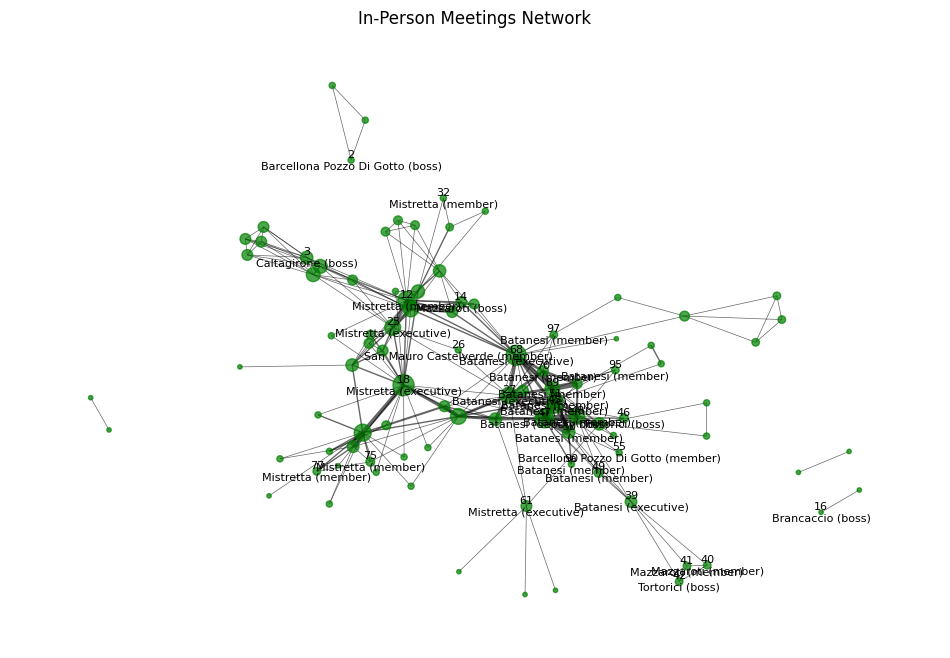

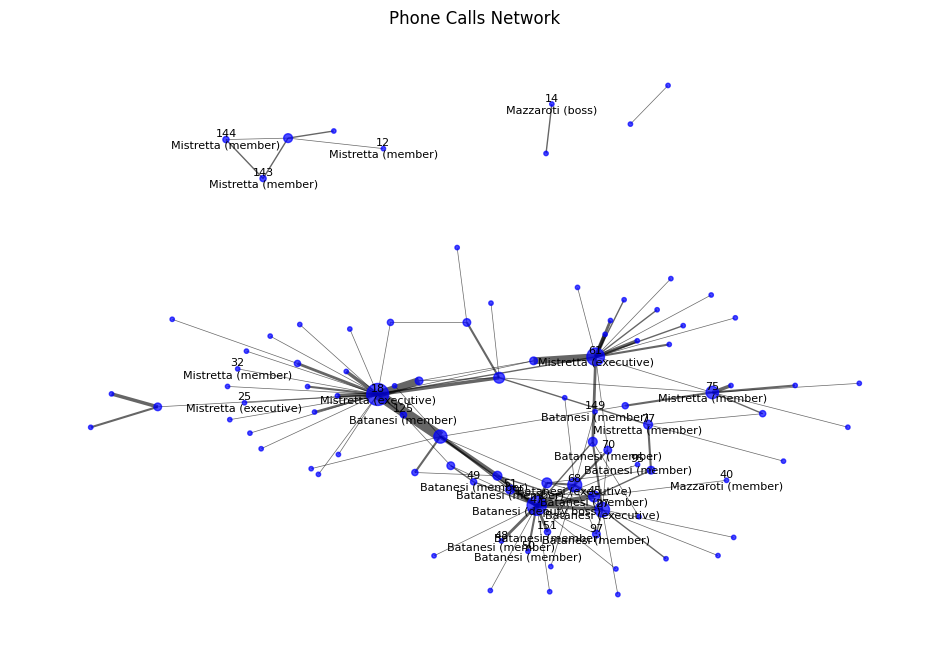

In [7]:
# Function to draw graphs. Scales node sizes by degree and edge widths by weight
def draw_graph(G, title, node_color='lightgray', edge_color='black'):
    plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * 10 for n in G.nodes()]  # Node size scaled by degree (scale factor = 10, can be adjusted)
    
    edge_weights = [G[u][v].get('weight', 1) * 0.5 for u, v in G.edges()]   # Edge width scaled by weight (scale factor = 0.5, can be adjusted)

    pos = nx.spring_layout(G, k=0.25, seed=42)  # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_color, alpha=0.6)
    #nx.draw_networkx_labels(G, pos, font_size=8)
    # If node has a role (not empty or nan), display it in the label
    labels = {
        n: f"{n}\n{data['Family']} ({data['Rank']})"
        for n, data in G.nodes(data=True)
        if 'Family' in data and 'Rank' in data  
        and pd.notna(data['Family']) and str(data['Family']).strip() != ''
        and pd.notna(data['Rank']) and str(data['Rank']).strip() != ''
    }
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')
    
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_graph(G_meetings, "In-Person Meetings Network", node_color='green')
draw_graph(G_calls, "Phone Calls Network", node_color='blue')

### Aggregated Graph

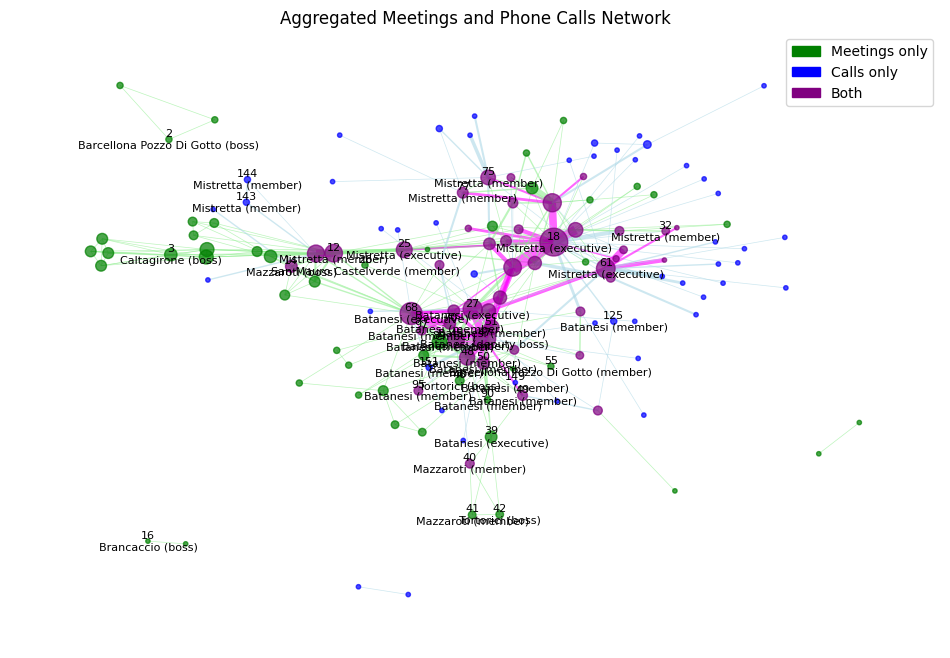

In [8]:
# Combine the two graphs in an "aggregated" graph
G_aggregated = nx.Graph(name="Aggregated Network")  # Create an empty graph for aggregation
# G_aggregated.add_edges_from(G_meetings.edges(data=True))  # data=True carries edge attributes (weights)
# G_aggregated.add_edges_from(G_calls.edges(data=True))     # Adds edges that are not already in the graph. Nodes in common are merged.

# Add meetings edges
for u, v, data in G_meetings.edges(data=True):
    w = data.get('weight', 1)
    if G_aggregated.has_edge(u, v):
        # If edge already exists, add the weight
        G_aggregated[u][v]['weight'] += w
        G_aggregated[u][v]['methods'].add('meetings')
    else:
        G_aggregated.add_edge(u, v, weight=w, methods={'meetings'})
# Add calls edges similarly
for u, v, data in G_calls.edges(data=True):
    w = data.get('weight', 1)
    if G_aggregated.has_edge(u, v):
        G_aggregated[u][v]['weight'] += w
        G_aggregated[u][v]['methods'].add('calls')
    else:
        G_aggregated.add_edge(u, v, weight=w, methods={'calls'})

# Add node roles to the aggregated graph
for node in G_aggregated.nodes():
    if node in role_info:
        nx.set_node_attributes(G_aggregated, {node: role_info[node]})

# Classify edges
edge_colors = []
for u, v in G_aggregated.edges():
    methods = G_aggregated[u][v]['methods']
    if methods == {'meetings'}:
        edge_colors.append('lightgreen')  # Meetings only
    elif methods == {'calls'}:
        edge_colors.append('lightblue')   # Calls only
    else:
        edge_colors.append('magenta') # Both

# Classify nodes
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())

node_colors = {}
for node in G_aggregated.nodes():
    in_meetings = node in nodes_meetings
    in_calls = node in nodes_calls
    if in_meetings and in_calls:
        node_colors[node] = 'purple'  # both
    elif in_meetings:
        node_colors[node] = 'green'   # only meetings
    elif in_calls:
        node_colors[node] = 'blue'    # only calls
colors_list = [node_colors[n] for n in G_aggregated.nodes()]  

# Node sizes (scaled by degree)
degrees = dict(G_aggregated.degree())
node_sizes = [degrees[n] * 10 for n in G_aggregated.nodes()]
edge_weights = [G_aggregated[u][v]['weight'] * 0.5 for u, v in G_aggregated.edges()]    # Edge thickness (scaled by weight, factor = 0.5)

pos = nx.spring_layout(G_aggregated, k=0.25, seed=42) # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
# Draw aggregated graph
nx.draw_networkx_nodes(G_aggregated, pos, node_color=colors_list, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G_aggregated, pos, width=edge_weights, edge_color=edge_colors, alpha=0.6)
#nx.draw_networkx_labels(G_aggregated, pos, font_size=8)
labels = {
        n: f"{n}\n{data['Family']} ({data['Rank']})"
        for n, data in G_aggregated.nodes(data=True)
        if 'Family' in data and 'Rank' in data  
        and pd.notna(data['Family']) and str(data['Family']).strip() != ''
        and pd.notna(data['Rank']) and str(data['Rank']).strip() != ''
    }
nx.draw_networkx_labels(G_aggregated, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')

# Add legend
import matplotlib.patches as mpatches
legend = [mpatches.Patch(color='green', label='Meetings only'),
          mpatches.Patch(color='blue', label='Calls only'),
          mpatches.Patch(color='purple', label='Both')]
plt.legend(handles=legend)
plt.axis('off')
plt.title("Aggregated Meetings and Phone Calls Network")
plt.show()

### Multilayer graph

In [9]:
# Create empty multilayer graph
G_multi = nx.Graph(name="Multilayer Network")

# Layer 0: Meetings
for u, v, data in G_meetings.edges(data=True):
    G_multi.add_edge((u, 0), (v, 0), weight=data.get('weight', 1), layer='meetings')
# Layer 1: Calls
for u, v, data in G_calls.edges(data=True):
    G_multi.add_edge((u, 1), (v, 1), weight=data.get('weight', 1), layer='calls')
# Add interlayer edges: (same person across layers)
common_nodes = set(G_meetings.nodes()) & set(G_calls.nodes())
for node in common_nodes:
    G_multi.add_edge((node, 0), (node, 1), weight=1, layer='interlayer')

# Add node roles to the multilayer graph
for node in G_multi.nodes():
    if node[0] in role_info:  # node[0] is the original node ID
        nx.set_node_attributes(G_multi, {node: role_info[node[0]]})

#test, print node data of node (2, 0)
#print(f"Node data for (2, 0): {G_multi.nodes[(2, 0)]}")

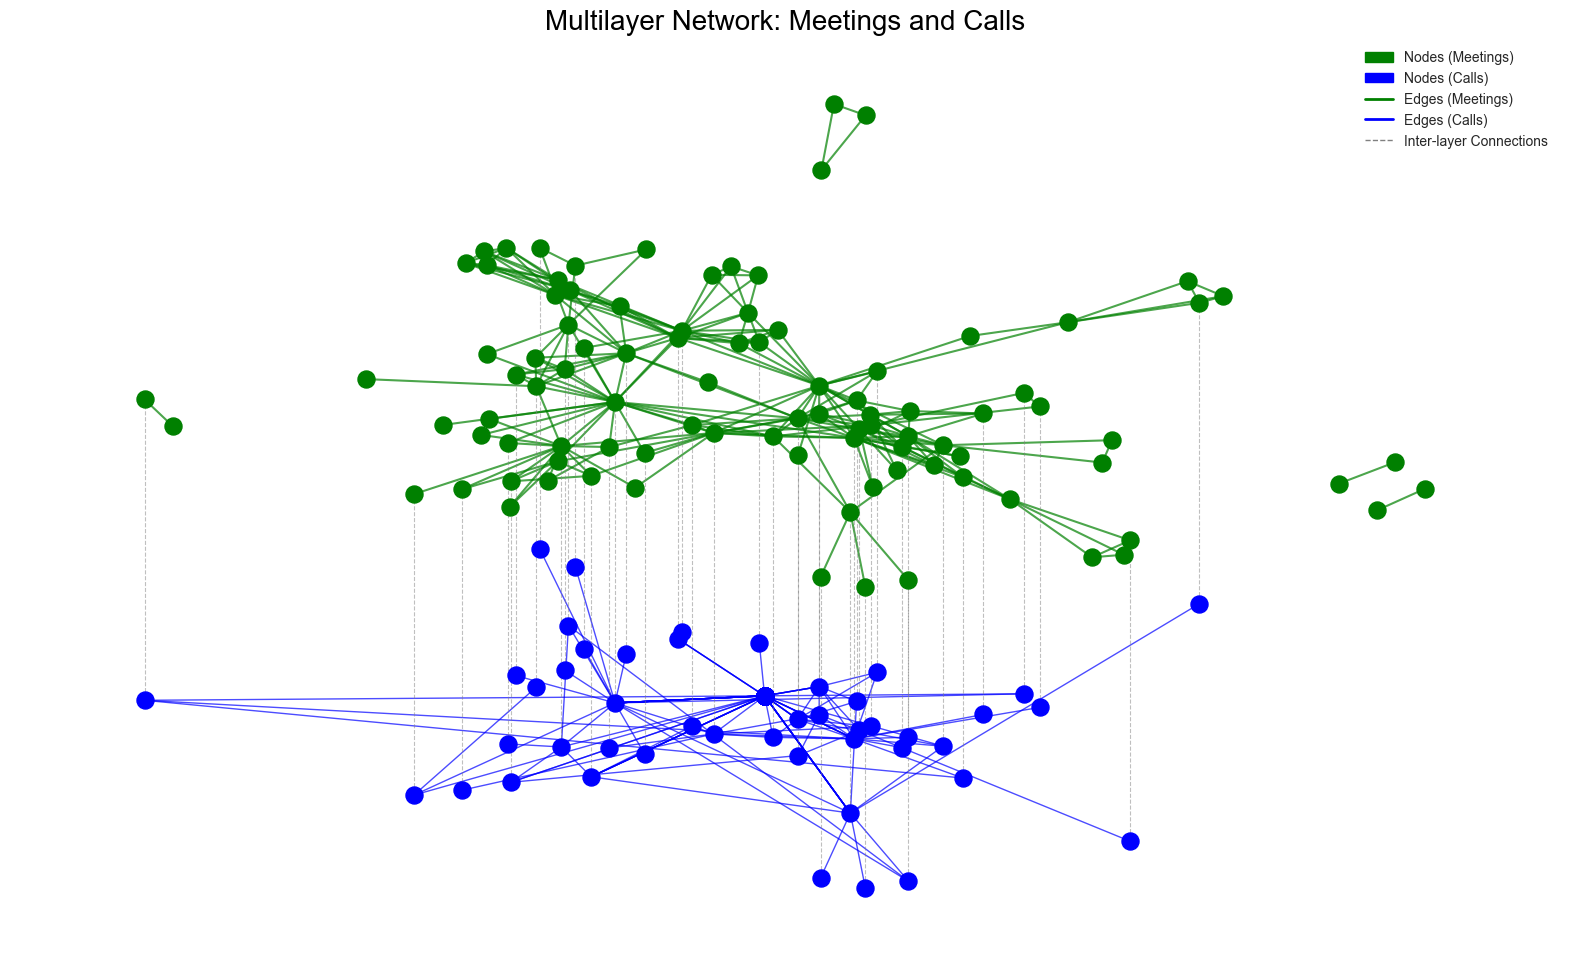

In [10]:
# Plot multilayer graph

def plot_multilayer_clean(G_multi, G_meetings, G_calls):
    
    pos_base = nx.spring_layout(G_meetings, seed=42, iterations=150, k=0.6)
    pos = {}
    layer_y_offset = {0: 1, 1: 0} # Set Y coordinates for each layer

    for node, layer in G_multi.nodes():
        if node not in pos_base:
            pos_base[node] = (0, 0)
        pos[(node, layer)] = (pos_base[node][0], pos_base[node][1] + layer_y_offset[layer])

    # Separate elements for drawing
    nodes_meetings = [(n, l) for n, l in G_multi.nodes() if l == 0]
    nodes_calls = [(n, l) for n, l in G_multi.nodes() if l == 1]
    
    edges_meetings = [(u, v) for u, v, d in G_multi.edges(data=True) if d.get('layer') == 'meetings']
    edges_calls = [(u, v) for u, v, d in G_multi.edges(data=True) if d.get('layer') == 'calls']
    edges_interlayer = [(u, v) for u, v, d in G_multi.edges(data=True) if d.get('layer') == 'interlayer']

    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 12))

    # Draw edges
    nx.draw_networkx_edges(G_multi, pos, edgelist=edges_meetings, edge_color='green', alpha=0.7, width=1.5, ax=ax)
    nx.draw_networkx_edges(G_multi, pos, edgelist=edges_calls, edge_color='blue', alpha=0.7, width=1.0, ax=ax)
    nx.draw_networkx_edges(G_multi, pos, edgelist=edges_interlayer, edge_color='gray', alpha=0.5, width=0.8, style='dashed', ax=ax)

    # Draw nodes
    nx.draw_networkx_nodes(G_multi, pos, nodelist=nodes_meetings, node_color='green', node_size=150, ax=ax)
    nx.draw_networkx_nodes(G_multi, pos, nodelist=nodes_calls, node_color='blue', node_size=150, ax=ax)
    

    # Set Legend
    ax.set_title('Multilayer Network: Meetings and Calls', fontsize=20, color='black')
    ax.axis('off')

    # Create legend
    legend_patches = [
        mpatches.Patch(color='green', label='Nodes (Meetings)'),
        mpatches.Patch(color='blue', label='Nodes (Calls)'),
        plt.Line2D([0], [0], color='green', lw=2, label='Edges (Meetings)'),
        plt.Line2D([0], [0], color='blue', lw=2, label='Edges (Calls)'),
        plt.Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Inter-layer Connections')
    ]
    ax.legend(handles=legend_patches, loc='upper right')
    
    plt.show()


plot_multilayer_clean(G_multi, G_meetings, G_calls)

### Graph analysis

In [11]:
# Find the nodes in common between the two graphs
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())
common_nodes = nodes_meetings & nodes_calls # Intersection

print(f"Nodes in common between Meetings and Phone Calls networks: {len(common_nodes)}")
print("Common nodes:", sorted(common_nodes))

Nodes in common between Meetings and Phone Calls networks: 46
Common nodes: [11, 12, 14, 18, 19, 21, 22, 23, 25, 27, 29, 31, 32, 33, 34, 36, 40, 43, 45, 47, 48, 49, 50, 51, 52, 54, 56, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 75, 77, 80, 95, 96, 97, 98, 99, 100]


In [61]:
# Function to print graph statistics. Statistics include:
# - Number of nodes, edges, and connected components
# - Max and average edge weight
# - Max and average node degree
# - Max shortest path length ("diameter") - Note: computes the diameter of the largest connected component
def print_graph_stats(G, name="Graph"):
    print(f"--- {name} ---")
    
    # Basic info (number of nodes, edges and components)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Connected components: {num_components}")
    
    # Edge weights
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    avg_weight = np.mean(edge_weights)
    print(f"Max edge weight: {max_weight}")
    print(f"Average edge weight: {avg_weight:.2f}")

    # Node degrees
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    avg_degree = np.mean(list(degrees.values()))
    print(f"Max node degree: {max_degree}")
    print(f"Average node degree: {avg_degree:.2f}")

    # Shortest path stats
    if nx.is_connected(G):  # Our graphs are disconnected, so this piece is always skipped
        diameter = nx.diameter(G)
        avg_shortest_path = nx.average_shortest_path_length(G)
    else:                   # Work on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        diameter = nx.diameter(G_sub)
        avg_shortest_path = nx.average_shortest_path_length(G_sub)
    print(f"Max shortest path length (diameter): {diameter}")
    print(f"Average shortest path length: {avg_shortest_path:.4f}")

    # Clustering coefficient
    # C(v) = (number of links between neighbors of v) / (maximum possible number of links between them)
    clustering_coeffs = nx.clustering(G)
    avg_clustering = np.mean(list(clustering_coeffs.values()))
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

    # Transitivity
    # Transitivity = (3 × number of triangles) / (number of connected triplets)
    transitivity = nx.transitivity(G)
    print(f"Transitivity: {transitivity:.4f}")
    
    print()  # Blank line for readability

In [64]:
print_graph_stats(G_meetings, name="Meetings Network")
print_graph_stats(G_calls, name="Phone Calls Network")
# print_graph_stats(G_aggregated, name="Aggregated Network")  # Note: there are 47 nodes *in common* between the two networks
# print_graph_stats(G_multi, name="Multilayer Network")

--- Meetings Network ---
Nodes: 95
Edges: 248
Connected components: 5
Max edge weight: 11.0
Average edge weight: 1.83
Max node degree: 23
Average node degree: 5.22
Max shortest path length (diameter): 6
Average shortest path length: 3.1070
Average clustering coefficient: 0.6688
Transitivity: 0.4085

--- Phone Calls Network ---
Nodes: 94
Edges: 120
Connected components: 4
Max edge weight: 15
Average edge weight: 2.30
Max node degree: 25
Average node degree: 2.55
Max shortest path length (diameter): 7
Average shortest path length: 3.3325
Average clustering coefficient: 0.1180
Transitivity: 0.0838



In [15]:
# Function to print top X heaviest edges
def print_top_weight_edges(G, top_x=10):
    # Get all edges with weights
    edges_with_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if 'weight' in d]
    
    # Sort by weight descending
    top_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)[:top_x]
    
    print(f"Top {top_x} heaviest edges (u, v, weight):")
    for u, v, w in top_edges:
        print(f"{u} -- {v} (weight: {w})")

# Function to print top X nodes by degree
def print_top_degree_nodes(G, top_x=10):
    # Compute degrees
    degrees = G.degree()
    
    # Sort by degree descending
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:top_x]
    
    print(f"Top {top_x} nodes by degree (node, degree):")
    for node, deg in top_nodes:
        print(f"{node} (degree: {deg})")

In [16]:
print("Meetings Network:")
print_top_degree_nodes(G_meetings, top_x=10)
print_top_weight_edges(G_meetings, top_x=10)

print("Phone Calls Network:")
print_top_degree_nodes(G_calls, top_x=10)
print_top_weight_edges(G_calls, top_x=10)

print("Aggregated Network:")
print_top_degree_nodes(G_aggregated, top_x=10)
print_top_weight_edges(G_aggregated, top_x=10)

print("Multilayer Network:")
print_top_degree_nodes(G_multi, top_x=10)
print_top_weight_edges(G_multi, top_x=10)

Meetings Network:
Top 10 nodes by degree (node, degree):
18 (degree: 23)
68 (degree: 21)
47 (degree: 18)
12 (degree: 16)
22 (degree: 15)
27 (degree: 14)
25 (degree: 13)
29 (degree: 13)
11 (degree: 12)
45 (degree: 12)
Top 10 heaviest edges (u, v, weight):
22 -- 76 (weight: 11)
11 -- 12 (weight: 10)
47 -- 50 (weight: 10)
47 -- 45 (weight: 9)
47 -- 48 (weight: 8)
89 -- 93 (weight: 8)
68 -- 89 (weight: 7)
27 -- 47 (weight: 7)
70 -- 89 (weight: 7)
18 -- 22 (weight: 6)
Phone Calls Network:
Top 10 nodes by degree (node, degree):
18 (degree: 25)
47 (degree: 19)
61 (degree: 16)
27 (degree: 11)
68 (degree: 10)
29 (degree: 9)
75 (degree: 8)
22 (degree: 6)
45 (degree: 6)
54 (degree: 5)
Top 10 heaviest edges (u, v, weight):
18 -- 29 (weight: 15)
18 -- 19 (weight: 11)
61 -- 66 (weight: 10)
47 -- 45 (weight: 7)
18 -- 33 (weight: 6)
29 -- 43 (weight: 6)
61 -- 128 (weight: 6)
43 -- 47 (weight: 6)
18 -- 22 (weight: 5)
18 -- 100 (weight: 5)
Aggregated Network:
Top 10 nodes by degree (node, degree):
18 (d

### Further analysis

#### Centrality Metrics

In [17]:
def degree_centrality(G):   # degree divided by (n-1), where n is the number of nodes
    """Unweighted degree centrality."""
    return nx.degree_centrality(G)

def weighted_degree_centrality(G):  # same as degree centrality, but considers edge weights
    """Weighted degree centrality (node strength)."""
    n = len(G)
    return {node: sum(d['weight'] for _, _, d in G.edges(node, data=True)) / (n-1) for node in G.nodes()}

def betweenness_centrality(G, weight=None):     # Importance is defined as the number of shortest paths that pass through a node
    """Betweenness centrality, optionally weighted."""
    return nx.betweenness_centrality(G, weight=weight)

def katz_centrality(G, alpha=0.1, beta=1.0):    # Importance is defined based on the importance of neighboring nodes
    """Katz centrality using numpy method for stability."""
    try:
        return nx.katz_centrality_numpy(G, alpha=alpha, beta=beta, weight='weight')
    except nx.NetworkXException as e:
        print("Katz centrality error:", e)
        return {}

def collective_influence(G, radius=2):          # Importance is defined based on the influence of neighboring nodes within a certain radius
    """Collective Influence centrality as defined in Morone & Makse (2015)."""
    CI = {}
    for node in G.nodes():
        ki = G.degree(node)
        if ki <= 1:
            CI[node] = 0
            continue
        ball = nx.ego_graph(G, node, radius=radius, center=False)
        boundary = set(ball.nodes())
        sigma = sum(G.degree(n) - 1 for n in boundary)
        CI[node] = (ki - 1) * sigma
    return CI

def pagerank(G, alpha=0.85, weight='weight'):   # Importance is defined based on the probability of random walks to cross that node
    """PageRank centrality, weighted by default."""
    return nx.pagerank(G, alpha=alpha, weight=weight)

In [18]:
arr_deg_meetings = degree_centrality(G_meetings)
arr_wdeg_meetings = weighted_degree_centrality(G_meetings)
arr_btw_meetings = betweenness_centrality(G_meetings, weight='weight')
arr_katz_meetings = katz_centrality(G_meetings)
arr_ci_meetings = collective_influence(G_meetings, radius=2)
arr_pr_meetings = pagerank(G_meetings)

arr_deg_calls = degree_centrality(G_calls)
arr_wdeg_calls = weighted_degree_centrality(G_calls)
arr_btw_calls = betweenness_centrality(G_calls, weight='weight')
arr_katz_calls = katz_centrality(G_calls)
arr_ci_calls = collective_influence(G_calls, radius=2)
arr_pr_calls = pagerank(G_calls)

arr_deg_aggregated = degree_centrality(G_aggregated)
arr_wdeg_aggregated = weighted_degree_centrality(G_aggregated)
arr_btw_aggregated = betweenness_centrality(G_aggregated, weight='weight')
arr_katz_aggregated = katz_centrality(G_aggregated)
arr_ci_aggregated = collective_influence(G_aggregated, radius=2)
arr_pr_aggregated = pagerank(G_aggregated)

arr_deg_multilayer = degree_centrality(G_multi)
arr_wdeg_multilayer = weighted_degree_centrality(G_multi)
arr_btw_multilayer = betweenness_centrality(G_multi, weight='weight')
arr_katz_multilayer = katz_centrality(G_multi)
arr_ci_multilayer = collective_influence(G_multi, radius=2)
arr_pr_multilayer = pagerank(G_multi)

In [19]:
# DEBUG - Print all measures
print("Degree Centrality (Meetings):", arr_deg_meetings)
print("Weighted Degree Centrality (Meetings):", arr_wdeg_meetings)
print("Betweenness Centrality (Meetings):", arr_btw_meetings)
print("Katz Centrality (Meetings):", arr_katz_meetings)
print("Collective Influence (Meetings):", arr_ci_meetings)
print("PageRank (Meetings):", arr_pr_meetings)
print("")
print("Degree Centrality (Calls):", arr_deg_calls)
print("Weighted Degree Centrality (Calls):", arr_wdeg_calls)
print("Betweenness Centrality (Calls):", arr_btw_calls)
print("Katz Centrality (Calls):", arr_katz_calls)
print("Collective Influence (Calls):", arr_ci_calls)
print("PageRank (Calls):", arr_pr_calls)
print("")
print("Degree Centrality (Aggregated):", arr_deg_aggregated)
print("Weighted Degree Centrality (Aggregated):", arr_wdeg_aggregated)
print("Betweenness Centrality (Aggregated):", arr_btw_aggregated)
print("Katz Centrality (Aggregated):", arr_katz_aggregated)
print("Collective Influence (Aggregated):", arr_ci_aggregated)
print("PageRank (Aggregated):", arr_pr_aggregated)
print("")
print("Degree Centrality (Multilayer):", arr_deg_multilayer)
print("Weighted Degree Centrality (Multilayer):", arr_wdeg_multilayer)
print("Betweenness Centrality (Multilayer):", arr_btw_multilayer)
print("Katz Centrality (Multilayer):", arr_katz_multilayer)
print("Collective Influence (Multilayer):", arr_ci_multilayer)
print("PageRank (Multilayer):", arr_pr_multilayer)

Degree Centrality (Meetings): {0: 0.02127659574468085, 1: 0.02127659574468085, 2: 0.02127659574468085, 3: 0.0851063829787234, 4: 0.06382978723404255, 5: 0.10638297872340426, 6: 0.10638297872340426, 7: 0.06382978723404255, 8: 0.06382978723404255, 9: 0.06382978723404255, 11: 0.1276595744680851, 12: 0.1702127659574468, 25: 0.13829787234042554, 28: 0.05319148936170213, 10: 0.05319148936170213, 13: 0.06382978723404255, 14: 0.06382978723404255, 68: 0.22340425531914893, 18: 0.24468085106382978, 85: 0.0851063829787234, 21: 0.02127659574468085, 84: 0.0425531914893617, 86: 0.0425531914893617, 87: 0.0425531914893617, 16: 0.010638297872340425, 17: 0.010638297872340425, 19: 0.09574468085106383, 20: 0.02127659574468085, 22: 0.1595744680851064, 23: 0.0851063829787234, 27: 0.14893617021276595, 29: 0.13829787234042554, 31: 0.02127659574468085, 34: 0.06382978723404255, 35: 0.05319148936170213, 43: 0.0851063829787234, 47: 0.19148936170212766, 59: 0.02127659574468085, 60: 0.02127659574468085, 63: 0.042553

In [20]:
# Print top X nodes based on a centrality measure (dicts of (node:value) sorted by value)
def print_top_centrality(arr, top_x=10):
    """Prints top X nodes by centrality measure."""
    sorted_nodes = sorted(arr.items(), key=lambda x: x[1], reverse=True)[:top_x]
    print(f"Top {top_x} nodes by centrality measure:")
    for node, value in sorted_nodes:
        print(f"{node}: {value:.4f}")

In [21]:
print_top_centrality(arr_btw_aggregated, top_x=10)
print_top_centrality(arr_btw_multilayer, top_x=10)

Top 10 nodes by centrality measure:
18: 0.4485
68: 0.2245
47: 0.1986
61: 0.1525
43: 0.1373
11: 0.1275
27: 0.1122
75: 0.0895
76: 0.0625
29: 0.0595
Top 10 nodes by centrality measure:
(18, 0): 0.3431
(68, 0): 0.1937
(18, 1): 0.1771
(47, 0): 0.1529
(61, 1): 0.1092
(61, 0): 0.1040
(11, 0): 0.1003
(27, 0): 0.0947
(43, 0): 0.0936
(47, 1): 0.0768


In [22]:
# Function to print table of top X nodes by degree centrality
# 4 columns: one for the nodes, 3 for the deg. centrality of the aggregated, the meetings and the calls graphs. Sorts nodes by degree centrality value of the aggregated graph.
def print_top_degree_table(arr_aggregated, arr_meetings, arr_calls, role_info, top_x=10, unnormalized=False):
    """Prints a table of top X nodes by degree centrality, with roles."""
    sorted_nodes = sorted(arr_aggregated.items(), key=lambda x: x[1], reverse=True)[:top_x]
    
    print(f"{'Node':<6} {'Role_Raw':<40} {'Aggregated':<10} {'Meetings':<10} {'Calls':<10}")
    print("-" * 80)
    
    for node, value in sorted_nodes:
        meetings_value = arr_meetings.get(node, 0)
        calls_value = arr_calls.get(node, 0)
        role = role_info.get(node, {}).get('Role_Raw', '')  # safely get role

        if unnormalized:
            value = round(value * (len(arr_aggregated) - 1))
            meetings_value = round(meetings_value * (len(arr_meetings) - 1))
            calls_value = round(calls_value * (len(arr_calls) - 1))
            print(f"{node:<6} {role:<40} {value:<10} {meetings_value:<10} {calls_value:<10}")
        else:
            print(f"{node:<6} {role:<40} {value:<10.4f} {meetings_value:<10.4f} {calls_value:<10.4f}")

In [23]:
print_top_degree_table(arr_deg_aggregated, arr_deg_meetings, arr_deg_calls, role_info, top_x=10, unnormalized=True)
print("")
print_top_degree_table(arr_deg_aggregated, arr_deg_meetings, arr_deg_calls, role_info, top_x=10, unnormalized=False)

Node   Role_Raw                                 Aggregated Meetings   Calls     
--------------------------------------------------------------------------------
18     executive family ''Mistretta''           40         23         25        
47     deputy boss family ''Batanesi''          26         18         19        
68     executive family ''Batanesi''            25         21         10        
27     executive family ''Batanesi''            19         14         11        
61     executive family ''Mistretta''           18         6          16        
22     Pharmacist-member                        17         15         6         
12     member family ''Mistretta''              16         16         1         
29     enterpreneur                             16         13         9         
11     boss Cosa Nostra in Messina              15         12         4         
45     member family ''Batanesi''               14         12         6         

Node   Role_Raw            

#### Groups and Clustering metrics

In [40]:
from networkx.algorithms.community import greedy_modularity_communities
from matplotlib import cm
from matplotlib.patches import Patch
import community as community_louvain
import igraph as ig     #pip install
import leidenalg        #pip install

# Function to compute greedy modularity communities
def compute_greedy_communities(G):
    """Compute communities using greedy modularity."""
    return list(greedy_modularity_communities(G))

# Function to compute communities using the Louvain method
def compute_louvain_communities(G):
    """Compute communities using the Louvain method."""
    partition = community_louvain.best_partition(G, weight='weight')
    communities = {}
    for node, com in partition.items():
        if com not in communities:
            communities[com] = []
        communities[com].append(node)
    return list(communities.values())

# Function to compute communities using the Leiden method
def compute_leiden_communities(G):
    """
    Converts a NetworkX graph to an iGraph graph and computes communities using the Leiden algorithm.
    All edge weights are cast to float, as required by Leiden.
    """
    # Build edge list with float weights
    edge_list = []
    for u, v, data in G.edges(data=True):
        weight = float(data.get('weight', 1.0))  # Convert to float
        edge_list.append((u, v, weight))

    # Ensure consistent node indexing (igraph uses consecutive integers)
    name_to_index = {name: idx for idx, name in enumerate(G.nodes())}
    indexed_edges = [(name_to_index[u], name_to_index[v], w) for u, v, w in edge_list]
    index_to_name = {idx: name for name, idx in name_to_index.items()}

    # Create iGraph graph
    g_ig = ig.Graph()
    g_ig.add_vertices(len(name_to_index))
    g_ig.add_edges([(u, v) for u, v, _ in indexed_edges])
    g_ig.es['weight'] = [w for _, _, w in indexed_edges]

    # Run Leiden algorithm
    partition = leidenalg.find_partition(
        g_ig,
        leidenalg.ModularityVertexPartition,
        weights=g_ig.es['weight']
    )

    # Translate communities back to original node names
    communities = [[index_to_name[idx] for idx in community] for community in partition]

    return communities


# Function to draw a graph with communities colored differently
def draw_communities(G, communities, title='Community Graph'):
    """Draw a graph where each community is colored differently and add a legend."""
    color_map = {}
    cmap = plt.colormaps.get_cmap('tab20')  # Safe for up to 20 distinct groups

    legend_patches = []
    for i, community in enumerate(communities):
        color = cmap(i / max(1, len(communities) - 1))  # Normalize index to 0–1
        for node in community:
            color_map[node] = color
        legend_patches.append(Patch(color=color, label=f"Community {i+1}"))

    node_colors = [color_map.get(node, 'gray') for node in G.nodes()]
    pos = nx.spring_layout(G, k=0.25, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.85)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.legend(handles=legend_patches, loc='best', fontsize=8)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Meetings Network - Greedy Communities:
  Community 1: frozenset({68, 69, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 36, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55})
  Community 2: frozenset({64, 65, 71, 72, 75, 76, 77, 78, 18, 21, 22, 26, 27, 29, 30, 31, 98, 99, 43, 59, 60, 63})
  Community 3: frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 84, 85, 86, 87, 25, 28})
  Community 4: frozenset({32, 33, 34, 35, 100, 19, 20, 23, 88, 24})
  Community 5: frozenset({80, 81, 82, 83, 79})
  Community 6: frozenset({40, 41, 42, 39})
  Community 7: frozenset({66, 67, 61, 62})
  Community 8: frozenset({0, 1, 2})
  Community 9: frozenset({16, 17})
  Community 10: frozenset({56, 57})
  Community 11: frozenset({73, 74})


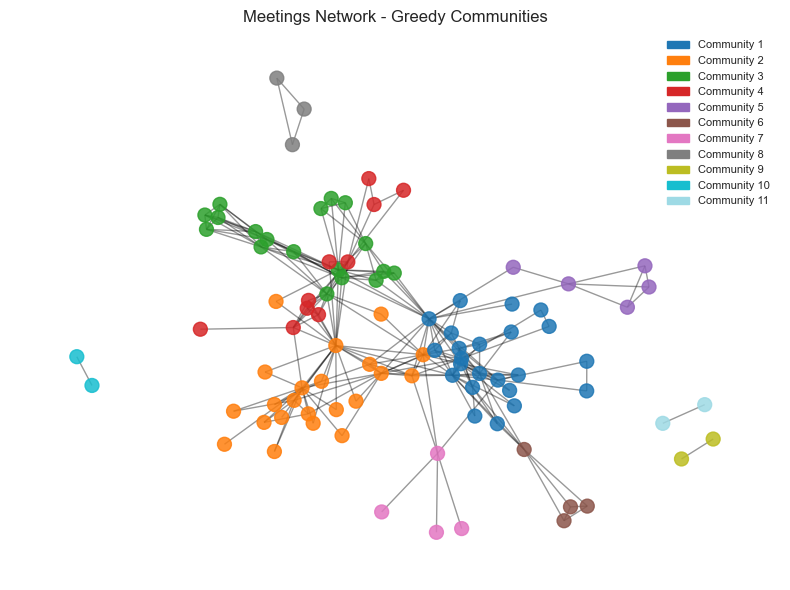

Phone Calls Network - Greedy Communities:
  Community 1: frozenset({66, 132, 71, 140, 18, 19, 146, 21, 22, 25, 153, 31, 32, 33, 34, 100, 102, 103, 104, 108, 109, 110, 111, 52, 124, 127})
  Community 2: frozenset({139, 147, 29, 95, 96, 98, 43, 47, 48, 49, 50, 51, 56, 121, 123, 125, 63})
  Community 3: frozenset({128, 129, 130, 67, 131, 133, 134, 105, 80, 117, 61, 62})
  Community 4: frozenset({97, 36, 70, 136, 138, 148, 119, 27, 126})
  Community 5: frozenset({68, 69, 40, 45, 149, 54, 151, 150, 152})
  Community 6: frozenset({64, 137, 75, 77, 112, 113, 114, 115, 116})
  Community 7: frozenset({144, 145, 11, 12, 143})
  Community 8: frozenset({99, 118, 23})
  Community 9: frozenset({101, 14})
  Community 10: frozenset({106, 107})


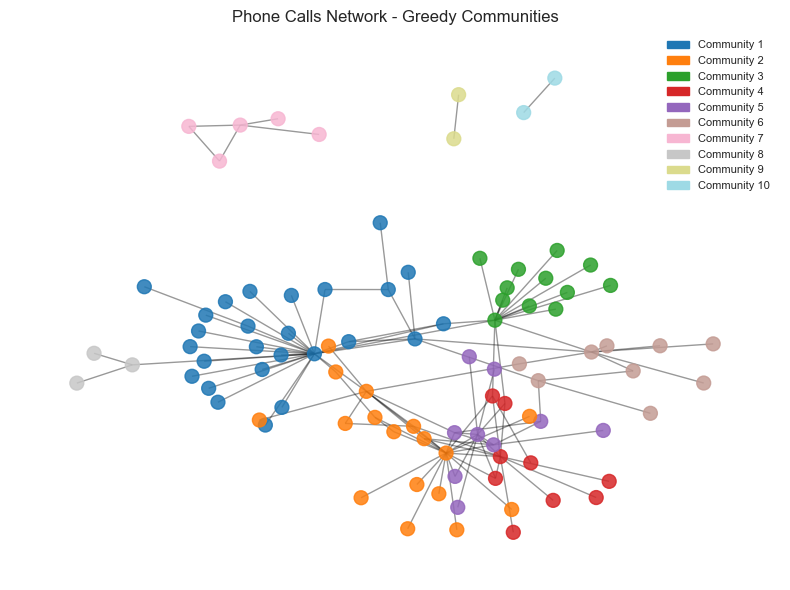

Meetings Network - Louvain Communities:
  Community 1: [0, 1, 2]
  Community 2: [3, 4, 5, 6, 7, 8, 9, 11, 12, 25, 28, 10, 13, 14, 85, 84, 86, 87, 26]
  Community 3: [68, 27, 47, 45, 51, 70, 89, 97, 54, 36, 46, 48, 91, 92, 49, 50, 55, 94, 90, 93, 95, 69]
  Community 4: [18, 21, 22, 29, 31, 43, 59, 60, 63, 64, 65, 71, 76, 30, 72, 75, 77, 78, 98, 99]
  Community 5: [16, 17]
  Community 6: [19, 20, 23, 34, 35, 100, 32, 33, 88, 24]
  Community 7: [61, 62, 66, 67]
  Community 8: [39, 40, 41, 42]
  Community 9: [52, 96]
  Community 10: [56, 57]
  Community 11: [79, 83, 80, 81, 82]
  Community 12: [73, 74]


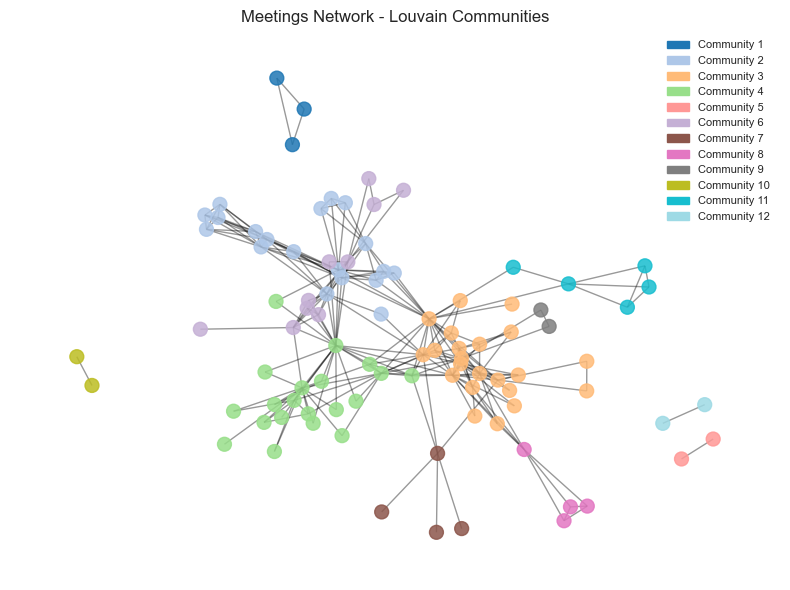

Phone Calls Network - Louvain Communities:
  Community 1: [11, 12, 143, 144, 145]
  Community 2: [14, 101]
  Community 3: [18, 19, 21, 22, 25, 29, 32, 33, 34, 52, 71, 100, 102, 103, 104, 108, 110, 125, 127, 132, 140, 146, 153, 31, 109, 63, 98, 139, 124, 111]
  Community 4: [61, 66, 36, 148, 62, 67, 80, 105, 117, 128, 129, 130, 131, 133, 134]
  Community 5: [99, 23, 118]
  Community 6: [75, 77, 64, 69, 112, 113, 114, 115, 116, 137]
  Community 7: [27, 43, 47, 51, 68, 70, 97, 119, 126, 136, 138, 54, 40, 45, 48, 49, 50, 56, 95, 96, 121, 123, 147, 151, 149, 150, 152]
  Community 8: [106, 107]


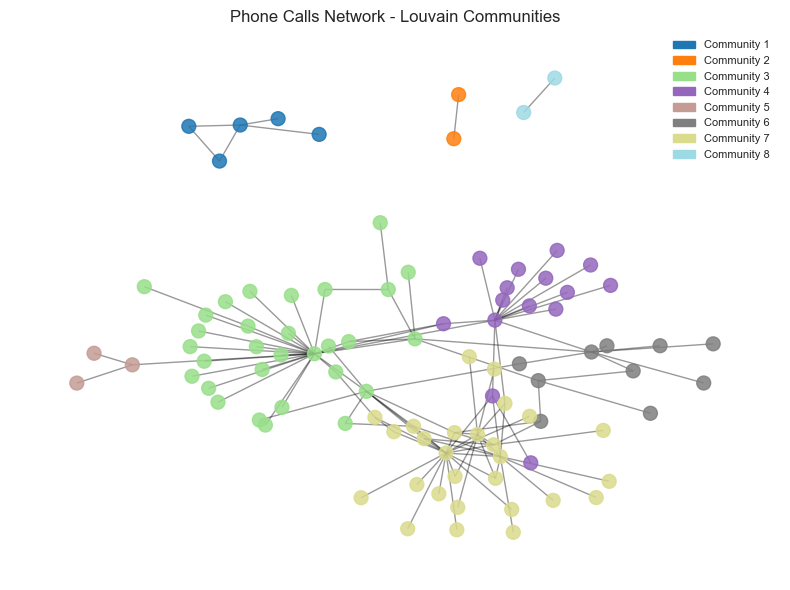

Meetings Network - Leiden Communities:
  Community 1: [18, 19, 20, 22, 23, 29, 31, 34, 35, 43, 59, 60, 63, 64, 65, 71, 76, 100, 32, 33, 88, 30, 72, 75, 77, 78, 98, 99, 24]
  Community 2: [68, 27, 47, 45, 51, 70, 89, 97, 54, 36, 46, 48, 91, 92, 50, 55, 94, 90, 93, 95, 69]
  Community 3: [3, 4, 5, 6, 7, 8, 9, 11, 12, 25, 28, 10, 13, 14, 85, 21, 84, 86, 87, 26]
  Community 4: [79, 83, 80, 81, 82]
  Community 5: [39, 40, 41, 42, 49]
  Community 6: [61, 62, 66, 67]
  Community 7: [0, 1, 2]
  Community 8: [16, 17]
  Community 9: [56, 57]
  Community 10: [73, 74]
  Community 11: [52, 96]


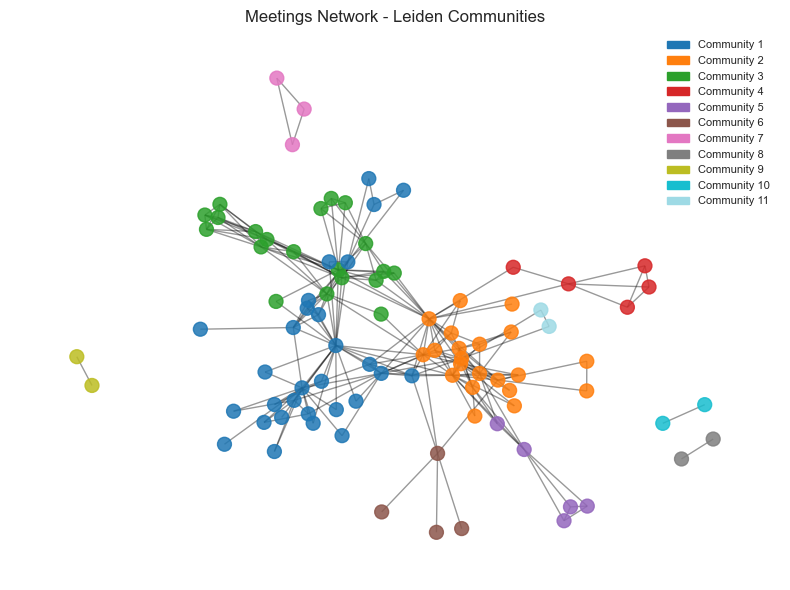

Phone Calls Network - Leiden Communities:
  Community 1: [27, 43, 47, 51, 68, 70, 97, 119, 126, 136, 138, 54, 40, 45, 48, 49, 50, 56, 95, 96, 121, 123, 147, 151, 149, 150, 152]
  Community 2: [18, 19, 21, 25, 29, 32, 33, 34, 52, 71, 100, 102, 103, 104, 108, 125, 127, 132, 140, 146, 153, 63, 98, 139, 124]
  Community 3: [61, 66, 36, 148, 62, 67, 80, 105, 117, 128, 129, 130, 131, 133, 134]
  Community 4: [22, 110, 31, 77, 109, 69, 137, 111]
  Community 5: [75, 64, 112, 113, 114, 115, 116]
  Community 6: [11, 12, 143, 144, 145]
  Community 7: [99, 23, 118]
  Community 8: [14, 101]
  Community 9: [106, 107]


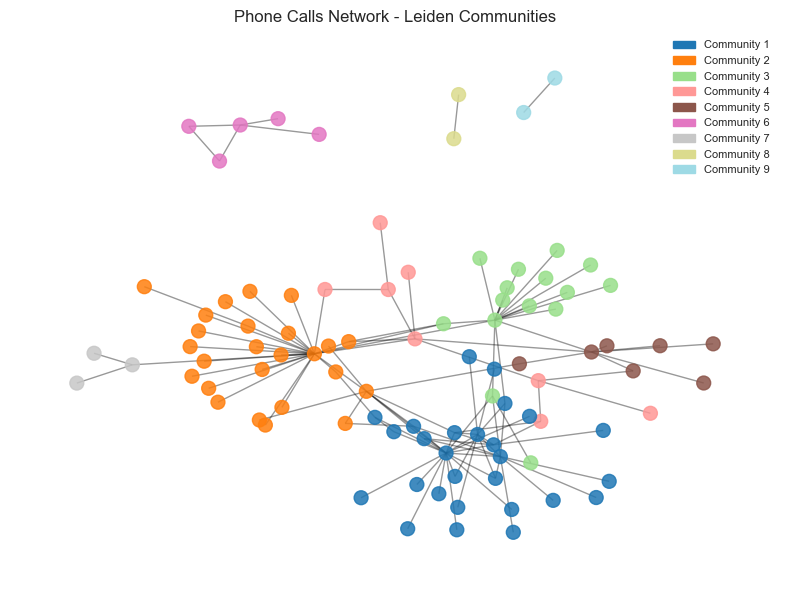

In [50]:
# Plot communities for each graph

graphs = {
    "Meetings Network": G_meetings,
    "Phone Calls Network": G_calls,
    # "Aggregated Network": G_aggregated,
    # "Multilayer Network": G_multi,
}

# Store communities and print / visualize them
communities_per_graph_greedy = {}
communities_per_graph_louvain = {}
communities_per_graph_leiden = {}

for name, G in graphs.items():
    communities_greedy = compute_greedy_communities(G)
    communities_per_graph_greedy[name] = communities_greedy
    communities_louvain = compute_louvain_communities(G)
    communities_per_graph_louvain[name] = communities_louvain
    communities_leiden = compute_leiden_communities(G)
    communities_per_graph_leiden[name] = communities_leiden

for name, communities in communities_per_graph_greedy.items():
    print(f"{name} - Greedy Communities:")
    for i, community in enumerate(communities):
        print(f"  Community {i+1}: {community}")
    draw_communities(graphs[name], communities, title=f"{name} - Greedy Communities")
for name, communities in communities_per_graph_louvain.items():
    print(f"{name} - Louvain Communities:")
    for i, community in enumerate(communities):
        print(f"  Community {i+1}: {community}")
    draw_communities(graphs[name], communities, title=f"{name} - Louvain Communities")
for name, communities in communities_per_graph_leiden.items():
    print(f"{name} - Leiden Communities:")
    for i, community in enumerate(communities):
        print(f"  Community {i+1}: {community}")
    draw_communities(graphs[name], communities, title=f"{name} - Leiden Communities")

In [51]:
from matplotlib.patches import Patch

def build_global_family_color_map(graphs):
    # Define the custom color map manually
    custom_colors = {
        'Barcellona Pozzo Di Gotto': "#377eb8", # 2
        'Caltagirone': '#035c00',               # 1
        'Mistretta': '#4daf4a',                 # 9, second most nodes
        'Mazzaroti': '#984ea3',                 # 3
        'Brancaccio': '#ff7f00',                # 1
        'San Mauro Castelverde': "#86451f",     # 1
        'Batanesi': '#e41a1c',                  # 17, most nodes
        'Tortorici': "#FF00D0",                 # 2
    }

    return custom_colors

family_color_map = build_global_family_color_map([G_meetings, G_calls, G_aggregated, G_multi])

# Function to draw a graph colored by mafia family
def draw_by_family_color(G, title='Graph Colored by Mafia Family', family_color_map=family_color_map, multilayer=False):

    # Determine node colors
    node_colors = []
    for node in G.nodes():
        data = G.nodes[node]
        fam = data.get('Family')
        if fam in family_color_map:
            node_colors.append(family_color_map[fam])
        else:
            node_colors.append('lightgray')

    # Create legend (once, only from provided map)
    legend_patches = [Patch(color=color, label=fam) for fam, color in family_color_map.items()]
    legend_patches.append(Patch(color='lightgray', label='No Family'))

    # Draw
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, alpha=0.85)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    plt.legend(handles=legend_patches, fontsize=8, loc='best')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


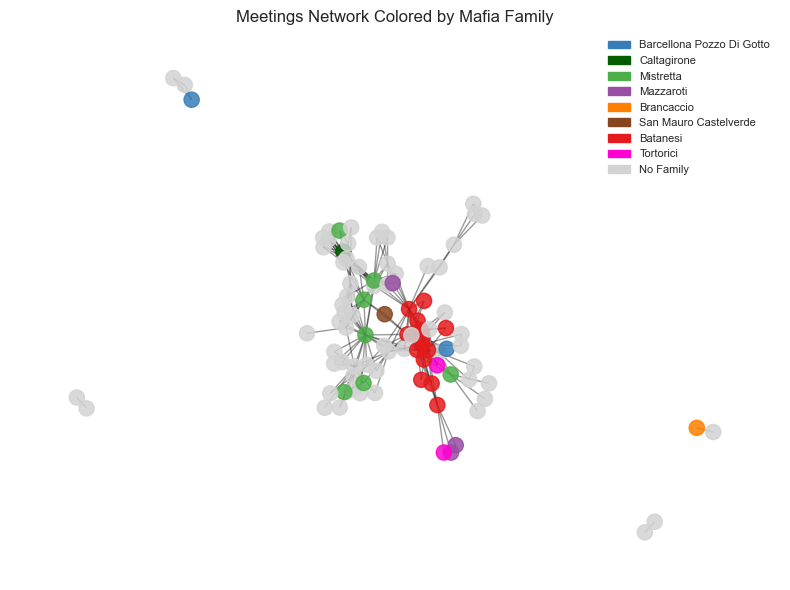

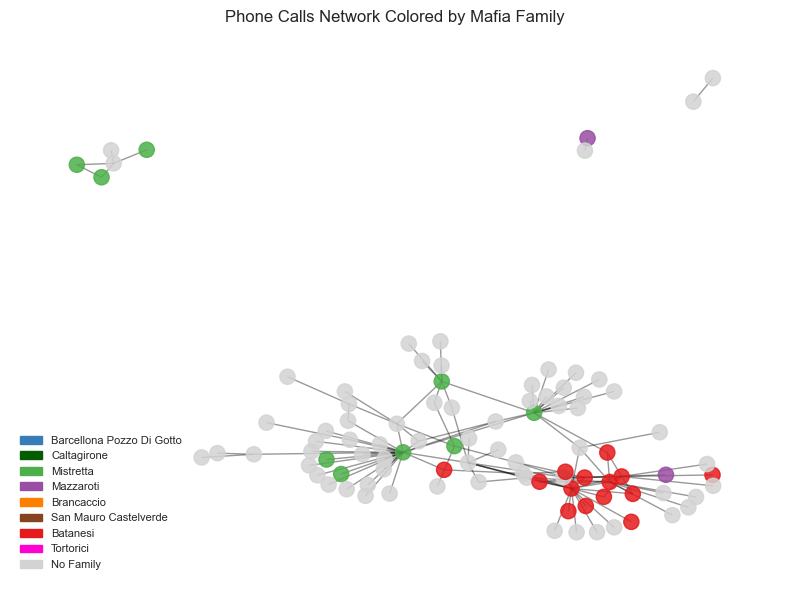

In [52]:
draw_by_family_color(G_meetings, "Meetings Network Colored by Mafia Family")
draw_by_family_color(G_calls, "Phone Calls Network Colored by Mafia Family")
# draw_by_family_color(G_aggregated, "Aggregated Network Colored by Mafia Family")
# draw_by_family_color(G_multi, "Multilayer Network Colored by Mafia Family", multilayer=True)

In [55]:
# Compare the clusters found with the real families
from collections import Counter, defaultdict

def compare_communities_to_families(G, communities):
    """
    Given a graph G with node attribute 'Family', and a list of communities (sets of nodes),
    compare each mafia family to the synthetic communities by overlap.

    Prints the family, its members, and the best-matching synthetic community.
    """

    # Build mapping from nodes to community index
    node_to_community = {}
    for i, comm in enumerate(communities):
        for node in comm:
            node_to_community[node] = i

    # Extract nodes with known families
    family_members = defaultdict(set)
    for node, data in G.nodes(data=True):
        fam = data.get('Family')
        if fam and str(fam).strip().lower() != 'none':
            family_members[fam].add(node)

    # Compare each family to each community
    for family, members in family_members.items():
        # Count overlaps with each community
        overlap_counts = Counter()
        for node in members:
            if node in node_to_community:
                comm_id = node_to_community[node]
                overlap_counts[comm_id] += 1

        if not overlap_counts:
            print(f"\nFamily '{family}' has no overlapping nodes with any detected community.")
            continue

        # Get best matching community
        best_comm_id, best_overlap = overlap_counts.most_common(1)[0]
        best_community = communities[best_comm_id]
        matched_nodes = sorted(set(best_community) & members)

        print(f" Family: {family}")
        print(f"  Real members {len(members)} node(s): {sorted(members)}")
        print(f"  Best community is n°{best_comm_id+1}: {sorted(set(best_community))}")
        print(f"  Overlap: {len(matched_nodes)} node(s): {matched_nodes}")
    print("")

In [59]:
# Apply comparison function to each graph's communities
for graph_name, G in graphs.items():
    for method, communities in zip(
        ['Greedy', 'Louvain', 'Leiden'],
        [communities_per_graph_greedy[graph_name], communities_per_graph_louvain[graph_name], communities_per_graph_leiden[graph_name]]
    ):
        print(f"\n{graph_name} - {method} Communities:")
        compare_communities_to_families(G, communities)


Meetings Network - Greedy Communities:
 Family: Barcellona Pozzo Di Gotto
  Real members 2 node(s): [2, 55]
  Best community is n°8: [0, 1, 2]
  Overlap: 1 node(s): [2]
 Family: Caltagirone
  Real members 1 node(s): [3]
  Best community is n°3: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 28, 84, 85, 86, 87]
  Overlap: 1 node(s): [3]
 Family: Mistretta
  Real members 7 node(s): [12, 18, 25, 32, 61, 75, 77]
  Best community is n°2: [18, 21, 22, 26, 27, 29, 30, 31, 43, 59, 60, 63, 64, 65, 71, 72, 75, 76, 77, 78, 98, 99]
  Overlap: 3 node(s): [18, 75, 77]
 Family: Mazzaroti
  Real members 3 node(s): [14, 40, 41]
  Best community is n°6: [39, 40, 41, 42]
  Overlap: 2 node(s): [40, 41]
 Family: Batanesi
  Real members 14 node(s): [27, 39, 45, 47, 48, 49, 50, 51, 68, 70, 89, 90, 95, 97]
  Best community is n°1: [36, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 68, 69, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97]
  Overlap: 12 node(s): [45, 47, 48, 49, 50, 51, 68, 70, 89, 90, 95, 97]
 Family: Brancac

Note: sembra che il metodo "Louvain" batta il "greedy" praticamente sempre.
Nella teoria, il metodo "Leiden" dovrebbe essere una versione più sofisticata di Louvain, ma nel nostro caso risulta praticamente identica, e dato che Leiden è molto più semplice da fare con networkx, manteniamo questo nel report.

### Clustering coefficient, Transitivity

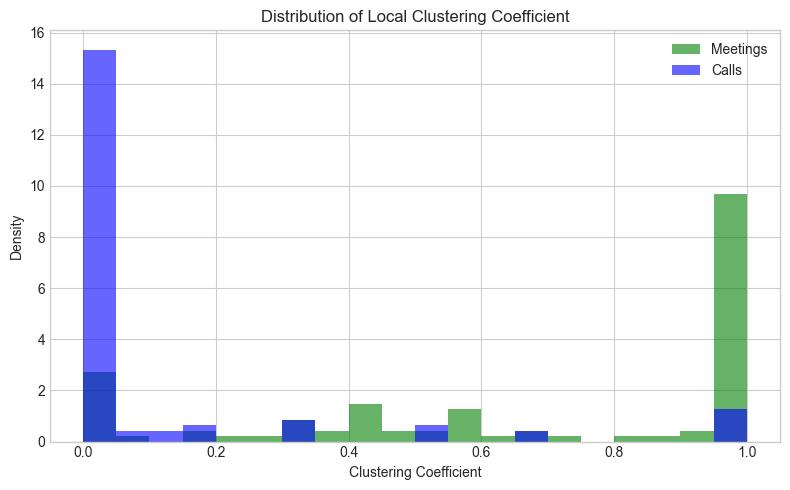

In [81]:
def plot_clustering_distribution(G1, G2, name1='Meetings', name2='Calls'):
    c1 = list(nx.clustering(G1).values())
    c2 = list(nx.clustering(G2).values())

    plt.figure(figsize=(8, 5))
    plt.hist(c1, bins=20, alpha=0.6, label=name1, density=True, color='green')
    plt.hist(c2, bins=20, alpha=0.6, label=name2, density=True, color='blue')
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Density")
    plt.title("Distribution of Local Clustering Coefficient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_clustering_distribution(G_meetings, G_calls, name1='Meetings', name2='Calls')

If the Meetings network has a clustering distribution skewed right (towards 1), it suggests that people who meet tend to form tight groups (trust-based, clique-like substructures).
If the Calls network skews left (towards 0), it may suggest that Phone communications are more spread-out, one-to-many, or hierarchical, a.k.a.generlally less tight. 

In [ ]:
# Average clustering coefficient and transitivity. This is a repeated stat.
avg_c_meetings = nx.average_clustering(G_meetings)
avg_c_calls = nx.average_clustering(G_calls)
trans_meetings = nx.transitivity(G_meetings)
trans_calls = nx.transitivity(G_calls)

print(f"Average clustering coefficient:\n  Meetings: {avg_c_meetings:.4f}\n  Calls:    {avg_c_calls:.4f}")
print(f"Transitivity:\n  Meetings: {trans_meetings:.4f}\n  Calls:    {trans_calls:.4f}")

Average clustering coefficient:
  Meetings: 0.6688
  Calls:    0.1180
Transitivity:
  Meetings: 0.4085
  Calls:    0.0838


### Other metric

In [ ]:
#redundancy, equivalences, homophily, small-worldness, scale freedom, cohesion, connectedness, compactness, triad census, core-periphery ...
#
